In [1]:
import numpy as np

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import grad, inner, split
from dolfinx import plot
from dolfinx.nls.petsc import NewtonSolver

from tqdm import tqdm

from mpi4py import MPI
from petsc4py import PETSc

import pyvista

# Simulation set up

In [2]:
nex = int(60)
ney = int(60)

#ele_type = "qua" 
#ele_type = "tri_enriched"
ele_type = "tri" 

if ele_type == "tri_enriched":
    cell_type = CellType.triangle
    enriched = True
elif ele_type == "tri":
    cell_type = CellType.triangle
    enriched = False
elif ele_type == "qua":
    cell_type = CellType.quadrilateral

In [3]:
from pathlib import Path

results_folder = Path(f"results/nonlinear_Naghdi/radial-hemisphere/{nex}_{ney}_{ele_type}")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista.start_xvfb()

# Mesh

In [4]:
r = 10.0
L = np.pi / 2 * r
W0 = (18. / 90.) * np.pi / 2 *r
W1 = np.pi / 2 *r
mesh = create_rectangle(MPI.COMM_WORLD, np.array([[W0, 0.0], [W1, L]]), [nex, ney], cell_type)

# topology dimension = 2
tdim = mesh.topology.dim
fdim = tdim - 1

## Plot mesh

In [5]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:36321/index.html?ui=P_0x7f8288519a60_0&reconnect=auto" class="pyvi…

# Material

In [6]:
E, nu = 6.825E7, 0.3
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = 0.04

# Initial shape

In [7]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0] / r)*ufl.cos(x[1] / r), 
                          r * ufl.sin(x[0] / r)*ufl.sin(x[1] / r), 
                          r * ufl.cos(x[0] / r)])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)

# for the 3 translation DOFs, we use the P2 + B3 enriched element
cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

# Director

In [8]:
# def tangent_2(n):
#     e3 = ufl.as_vector([0, 0, 1])
#     t2 = ufl.cross(e3, n)
#     t2 = t2/ufl.sqrt(inner(t2, t2))
#     return t2

# def tangent_1(n, t2):
#     t1 = ufl.cross(t2, n)
#     t1 = t1/ufl.sqrt(inner(t1, t1))
#     return t1

# # the analytical expression of t1 and t2
# t2_ufl = tangent_2(n0_ufl)
# t1_ufl = tangent_1(n0_ufl, t2_ufl)

def tangent_1(phi):
    t1 = phi.dx(0)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

t1_ufl = tangent_1(phi0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## Plot director

In [9]:
# create a FEM interpolation of t1, t2, n0 and phi0
t_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))
t1_expr = Expression(t1_ufl, t_FS.element.interpolation_points())
t1_func = Function(t_FS)
t1_func.interpolate(t1_expr)

t2_expr = Expression(t2_ufl, t_FS.element.interpolation_points())
t2_func = Function(t_FS)
t2_func.interpolate(t2_expr)

n0_expr = Expression(n0_ufl, t_FS.element.interpolation_points())
n0_func = Function(t_FS)
n0_func.interpolate(n0_expr)

phi0_P1_expr = Expression(phi0_ufl, t_FS.element.interpolation_points())
phi0_P1 = Function(t_FS)
phi0_P1.interpolate(phi0_P1_expr)

In [10]:
topology, cell_types, geometry = plot.vtk_mesh(t_FS)

geometry_phi0_P1 = phi0_P1.x.array.reshape((geometry.shape[0], len(phi0_P1)))
geometry_t1 = t1_func.x.array.reshape((geometry.shape[0], len(t1_func)))
geometry_t2 = t2_func.x.array.reshape((geometry.shape[0], len(t2_func)))
geometry_n0 = n0_func.x.array.reshape((geometry.shape[0], len(n0_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)

grid_phi0_P1["n0"] = geometry_n0
grid_phi0_P1["t1"] = geometry_t1
grid_phi0_P1["t2"] = geometry_t2

glyphs_n0 = grid_phi0_P1.glyph(orient="n0", factor=0.5)
glyphs_t1 = grid_phi0_P1.glyph(orient="t1", factor=0.5)
glyphs_t2 = grid_phi0_P1.glyph(orient="t2", factor=0.5)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k", line_width= 0.5)
plotter.add_mesh(glyphs_n0, color = 'b', show_scalar_bar=True)
plotter.add_mesh(glyphs_t1, color = 'r', show_scalar_bar=True)
plotter.add_mesh(glyphs_t2, color = 'g', show_scalar_bar=True)
plotter.camera_position = 'xz'
plotter.camera.azimuth = -45
plotter.camera.elevation = 15
plotter.show_axes_all()
plotter.enable_parallel_projection()
plotter.show()

Widget(value='<iframe src="http://localhost:36321/index.html?ui=P_0x7f8261826690_0&reconnect=auto" class="pyvi…

# Shell element

In [11]:
if ele_type == "tri_enriched":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri":
        naghdi_shell_element = mixed_element(
            [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )
    
elif ele_type == "qua":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [12]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# Weak form Equation with PSRI

In [13]:
# Full integration
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Reduced integration of order 2
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
W_ext = 0.0
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Symmetric BC

In [14]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

Q0 = naghdi_shell_FS.sub(0)
Q1 = naghdi_shell_FS.sub(1)

u_clamped = Function(u_FS) # default value is 0
theta_clamped = Function(theta_FS) # default value is 0

top: $u_1 = \theta_1 = 0$

In [15]:
def top_boundary(x):
    return np.isclose(x[1], L)

top_facets = locate_entities_boundary(mesh, fdim, top_boundary)

# u1 = 0 on the top boundary
u_id = int(0)
symm_dofs_u_top = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, top_facets)
bc_u_top = dirichletbc(u_clamped, symm_dofs_u_top, Q0.sub(u_id))

# theta1 = 0 on the top boundary
theta_id = int(0)
symm_dofs_theta_top = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, top_facets)
bc_theta_top = dirichletbc(theta_clamped, symm_dofs_theta_top, Q1.sub(theta_id))

bottom: $u_2 = \theta_1 = 0$

In [16]:
def bottom_boundary(x):
    return np.isclose(x[1], 0.0)

bottom_facets = locate_entities_boundary(mesh, fdim, bottom_boundary)

# u2 = 0 on the bottom boundary
u_id = int(1)
symm_dofs_u_bottom = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, bottom_facets)
bc_u_bottom = dirichletbc(u_clamped, symm_dofs_u_bottom, Q0.sub(u_id))

# theta1 = 0 on the top boundary
theta_id = int(0)
symm_dofs_theta_bottom = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, bottom_facets)
bc_theta_bottom = dirichletbc(theta_clamped, symm_dofs_theta_bottom, Q1.sub(theta_id))

remove rigid body motion in $z$ axis

In [17]:
def rigid_movement_boundary(x):
    return np.logical_and(np.isclose(x[0], W0), np.isclose(x[1], 0.0))

rigid_point = locate_entities_boundary(mesh, 0, rigid_movement_boundary)
u_id = int(2)
symm_dofs_u_rigid = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), 0, rigid_point)
bc_u_rigid = dirichletbc(u_clamped, symm_dofs_u_rigid, Q0.sub(u_id))

In [18]:
bcs = [bc_u_top, bc_theta_top, bc_u_bottom, bc_theta_bottom, bc_u_rigid]

# Point Source

In [19]:
def compute_cell_contributions(V, points, dir_id):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmaps[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(dir_id))
    num_dofs = V.sub(0).sub(dir_id).dofmap.dof_layout.num_dofs * V.sub(0).sub(dir_id).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))
        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [20]:
if mesh.comm.rank == 0:
    points_A = np.array([[W1, 0.0, 0.0]], dtype=mesh.geometry.x.dtype)
    points_B = np.array([[W1, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    points_A = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)
    points_B = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

dir_A = 0
dir_B = 1
ps_cells_A, basis_values_A = compute_cell_contributions(naghdi_shell_FS, points_A, dir_A)
ps_cells_B, basis_values_B = compute_cell_contributions(naghdi_shell_FS, points_B, dir_B)

# Solver

In [21]:
import typing
from dolfinx.fem.bcs import DirichletBC
from dolfinx.fem.function import Function as _Function
from dolfinx.fem.petsc import assemble_vector, apply_lifting, set_bc

class NonlinearProblemTwoPointSource(NonlinearProblem):
    def __init__(self, F: ufl.form.Form, u: _Function, bcs: typing.List[DirichletBC] = [],
                 J: ufl.form.Form = None, cells_A = [], basis_values_A = [], dir_A: int = 0,
                 cells_B = [], basis_values_B = [], dir_B: int = 1, 
                 PS_A: float = 0.0, PS_B: float = 0.0):
        
        super().__init__(F, u, bcs, J)
        
        self.PS_A = PS_A
        self.PS_B = PS_B
        self.cells_A = cells_A
        self.basis_values_A = basis_values_A
        self.dir_A = dir_A
        self.cells_B = cells_B
        self.basis_values_B = basis_values_B
        self.dir_B = dir_B
        self.function_space = u.function_space
        
    def F(self, x: PETSc.Vec, b: PETSc.Vec) -> None:
        # Reset the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        assemble_vector(b, self._L)

        # Add point source
        if len(self.cells_A) > 0:
            for cell, basis_value in zip(self.cells_A, self.basis_values_A):
                dofs = self.function_space.sub(0).sub(self.dir_A).dofmap.cell_dofs(cell)
                with b.localForm() as b_local:
                    b_local.setValuesLocal(dofs, basis_value * -self.PS_A, addv=PETSc.InsertMode.ADD_VALUES)
        
        if len(self.cells_B) > 0:
            for cell, basis_value in zip(self.cells_B, self.basis_values_B):
                dofs = self.function_space.sub(0).sub(self.dir_B).dofmap.cell_dofs(cell)
                with b.localForm() as b_local:
                    b_local.setValuesLocal(dofs, basis_value * -self.PS_B, addv=PETSc.InsertMode.ADD_VALUES)
                    
        # Apply boundary condition
        apply_lifting(b, [self._a], bcs=[self.bcs], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, self.bcs, x, -1.0)

In [22]:
problem = NonlinearProblemTwoPointSource(Residual, q_func, bcs, Jacobian,
                                         ps_cells_A, basis_values_A, dir_A,
                                         ps_cells_B, basis_values_B, dir_B)

solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 100
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [23]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")

bb_point_A = np.array([[W1, 0.0, 0.0]], dtype=np.float64)
bb_point_B = np.array([[W1, L, 0.0]], dtype=np.float64)
def write_files():
    phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
    if ele_type == "tri_enriched":
        u_P2B3 = q_func.sub(0).collapse()
        u_P2 = Function(phi_FS)
        u_P2.interpolate(u_P2B3)
    else:
        u_P2 = q_func.sub(0).collapse()
    
    phi_expr = Expression(phi0_ufl + u_P2, phi_FS.element.interpolation_points())
    phi_func = Function(phi_FS)
    phi_func.interpolate(phi_expr)
    theta_P2 = q_func.sub(1).collapse()

    file_u.write_function(u_P2, i)
    file_theta.write_function(theta_P2, i)
    file_phi.write_function(phi_func, i)

def point_values():
    UA_bb = None
    VB_bb = None
    
    u1_func = q_func.sub(0).sub(0).collapse()
    u2_func = q_func.sub(0).sub(1).collapse()
    
    if len(ps_cells_A) > 0:
        UA_bb = u1_func.eval(bb_point_A, ps_cells_A[0])[0]
    UA_bb = mesh.comm.gather(UA_bb, root=0)
    
    if len(ps_cells_B) > 0:
        VB_bb = u2_func.eval(bb_point_B, ps_cells_B[0])[0]
    VB_bb = mesh.comm.gather(VB_bb, root=0)
    
    return UA_bb, VB_bb

In [ ]:
PS_max = 200.0
n_step = 50
PS_diff = PS_max / n_step

if mesh.comm.rank == 0:
    UA_list = np.zeros(n_step + 1)
    VB_list = np.zeros(n_step + 1)
    PS_list = np.arange(0, PS_diff * (n_step + 1), PS_diff)

q_func.x.array[:] = 0.0

for i in tqdm(range(1, n_step + 1)):
    problem.PS_A = PS_diff * i
    problem.PS_B = - PS_diff * i
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {problem.PS_A :.2f}({PS_max:.2f})", flush=True)
    
    write_files()
    # calculate u3 at the point load
    UA_bb, VB_bb = point_values()
    if mesh.comm.rank == 0:
        for UA in UA_bb:
            if UA is not None:
                UA_list[i] = UA
                break
        
        for VB in VB_bb:
            if VB is not None:
                VB_list[i] = VB
                break


In [25]:
u_sol = q_func.sub(0).collapse()
theta_P2 = q_func.sub(1).collapse()

# Interpolate phi in the [P2]³ Space
phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)
topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:46369/index.html?ui=P_0x7fa271a1cbc0_1&reconnect=auto" class="pyvi…

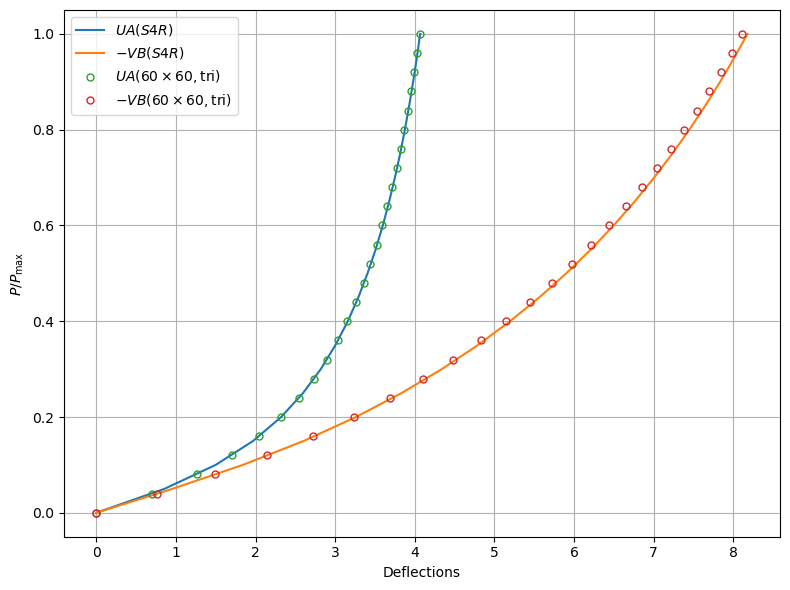

In [25]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    P_S4R = np.array([0.00, 0.050, 0.100, 0.150, 
                      0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                      0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
                      0.90, 0.95, 1.00])
    
    UA_S4R = np.array([0.00, 0.855, 1.499, 1.969, 2.321, 2.596, 2.819,
                       3.002, 3.158, 3.291, 3.406, 3.508, 3.598, 3.678, 3.750,
                       3.816, 3.875, 3.929, 3.979, 4.025, 4.067])
    VB_S4R = np.array([0.00, 0.955, 1.840, 2.604, 3.261, 3.833, 4.339, 4.790,
                       5.196, 5.565, 5.902, 6.212, 6.497, 6.761, 7.006, 7.234,
                       7.448, 7.647, 7.835, 8.011, 8.178])

    np.savetxt(results_folder/"UA.txt", UA_list)
    np.savetxt(results_folder/"VB.txt", VB_list)
    np.savetxt(results_folder/"Ps_Pmax.txt", PS_list/PS_max)
    
    plt.figure(figsize=(8.0, 6.0))
    plt.plot(UA_S4R, P_S4R, "-", label="$UA(S4R)$")
    plt.plot(VB_S4R, P_S4R, "-", label="$-VB(S4R)$")
    plt.plot(UA_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$UA({nex}\\times{ney},${ele_type})")
    
    plt.plot(-VB_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$-VB({nex}\\times{ney},${ele_type})")
    
    plt.xlabel("Deflections")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    #plt.xlim(0, 5)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png", dpi=300)